In [95]:
import pandas as pd
import requests
import gzip
from io import BytesIO, StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [96]:
# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [97]:
# Configuración de Plotly para notebooks
import plotly.io as pio
pio.renderers.default = "notebook"

In [98]:
GITHUB_RAW_URL = "https://raw.githubusercontent.com/Yael-Parra/Airbnb-Analysis/feature-eda-cleaning/data/airbnb_cleaned.csv.gz"

def load_airbnb_data_from_github(url):
    """
    Carga datos de AirBnB directamente desde GitHub
    """
    print("🔗 Descargando datos desde GitHub...")

    try:
        # Descargar archivo
        response = requests.get(url)
        response.raise_for_status()

        print("📊 Procesando archivo comprimido...")

        # Descomprimir y leer CSV
        with gzip.open(BytesIO(response.content), 'rt', encoding='utf-8') as f:
            df = pd.read_csv(f)

        print(f"✅ Datos cargados exitosamente!")
        print(f"   📋 Filas: {len(df):,}")
        print(f"   📋 Columnas: {len(df.columns)}")
        print(f"   📋 Ciudades: {df['city'].nunique() if 'city' in df.columns else 'N/A'}")

        return df

    except Exception as e:
        print(f"❌ Error al cargar datos: {e}")
        return None

# Cargar datos
df = load_airbnb_data_from_github(GITHUB_RAW_URL)

# Quick preview
if df is not None:
    print(f"\n📊 Info general:")
    print(df.info())

🔗 Descargando datos desde GitHub...
📊 Procesando archivo comprimido...
✅ Datos cargados exitosamente!
   📋 Filas: 220,031
   📋 Columnas: 17
   📋 Ciudades: 6

📊 Info general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220031 entries, 0 to 220030
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id_announcement                 220031 non-null  int64  
 1   title_announcement              220031 non-null  object 
 2   host_id                         220031 non-null  int64  
 3   host_name                       220031 non-null  object 
 4   city                            220031 non-null  object 
 5   neighbourhood_group             220031 non-null  object 
 6   neighbourhood                   220031 non-null  object 
 7   latitude                        220031 non-null  float64
 8   longitude                       220031 non-null  float64
 9   room_type                   

##1. Análisis univariado

- **Variables numéricas**: Histogramas, boxplots, estadísticas descriptivas (media, mediana, asimetría, curtosis)
- **Variables categóricas**: Frecuencias, gráficos de barras y pastel, análisis de distribución

In [99]:
def analyze_numerical_variables(df):
    """
    Análisis univariado de variables numéricas
    """
    print("\n🔢 ANÁLISIS DE VARIABLES NUMÉRICAS")
    print("-" * 40)

    # Se excluyen las variables numéricas que no interesa incluir en el análisis
    exclude_cols = ['id', 'host_id', 'latitude', 'longitude', 'id_announcement', 'reviews_per_month']
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in exclude_cols]


    print(f"Variables numéricas a analizar: {len(numeric_cols)}")
    for i, col in enumerate(numeric_cols, 1):
        print(f"  {i}. {col}")

    # Se crean subplots para los histogramas
    n_cols = int(np.ceil(np.sqrt(len(numeric_cols))))
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            # Histograma
            df[col].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')

            # Análisis estadístico
            mean_val = df[col].mean()
            median_val = df[col].median()
            axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.2f}')
            axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.2f}')
            axes[i].legend()

    # Se ocultan los subplots vacíos
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Boxplots para detectar outliers
    print("\n📦 Análisis de Outliers (Boxplots)")

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(f'Boxplot de {col}')
            axes[i].set_ylabel(col)

    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Estadísticas de asimetría y curtosis
    print("\n📊 Estadísticas de Forma de Distribución:")
    stats_df = pd.DataFrame({
        'Variable': numeric_cols,
        'Media': [df[col].mean() for col in numeric_cols],
        'Mediana': [df[col].median() for col in numeric_cols],
        'Desv_Std': [df[col].std() for col in numeric_cols],
        'Asimetría': [df[col].skew() for col in numeric_cols],
        'Curtosis': [df[col].kurtosis() for col in numeric_cols],
        'CV': [df[col].std()/df[col].mean()*100 for col in numeric_cols]
    })

    display(stats_df.round(3))

    return numeric_cols

In [100]:
def analyze_categorical_variables(df):
    """
    Análisis univariado de variables categóricas filtradas y ordenadas por relevancia
    """
    print("\n🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS")
    print("-" * 40)

    # Identificar todas las variables categóricas
    all_categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Se excluyen columnas irrelevantes o de alta cardinalidad
    excluded_cols = ['host_name', 'neighbourhood_group']
    filtered_categorical_cols = [
        col for col in all_categorical_cols
        if col not in excluded_cols and df[col].nunique() <= 1000
    ]

    # Ordenar por cardinalidad creciente (más fácil de visualizar)
    filtered_categorical_cols.sort(key=lambda col: df[col].nunique())

    print(f"Variables categóricas útiles encontradas: {len(filtered_categorical_cols)}")
    for i, col in enumerate(filtered_categorical_cols, 1):
        print(f"  {i}. {col} (únicos: {df[col].nunique()})")

    for col in filtered_categorical_cols:
        print(f"\n📋 Análisis de '{col}':")

        # Conteo de valores
        value_counts = df[col].value_counts()
        print(f"  Valores únicos: {df[col].nunique()}")
        print(f"  Valores más frecuentes:")
        for val, count in value_counts.head(10).items():
            percentage = (count / len(df)) * 100
            print(f"    {val}: {count:,} ({percentage:.1f}%)")

        # Gráfico de barras (Top N categorías)
        top_n = 10
        top_values = value_counts.head(top_n)
        plt.figure(figsize=(10, 5))
        if len(value_counts) <= top_n:
            top_values.plot(kind='bar', color='skyblue')
            plt.title(f'Frecuencia de {col}')
            plt.xlabel(col)
            plt.ylabel('Frecuencia')
            plt.xticks(rotation=45)
        else:
            top_values.plot(kind='barh', color='skyblue')
            plt.title(f'Frecuencia de {col} (Top {top_n})')
            plt.xlabel('Frecuencia')
            plt.ylabel(col)
        plt.tight_layout()
        plt.show()

    return filtered_categorical_cols



🔢 ANÁLISIS DE VARIABLES NUMÉRICAS
----------------------------------------
Variables numéricas a analizar: 5
  1. minimum_nights
  2. number_of_reviews
  3. calculated_host_listings_count
  4. availability_365
  5. price_USD


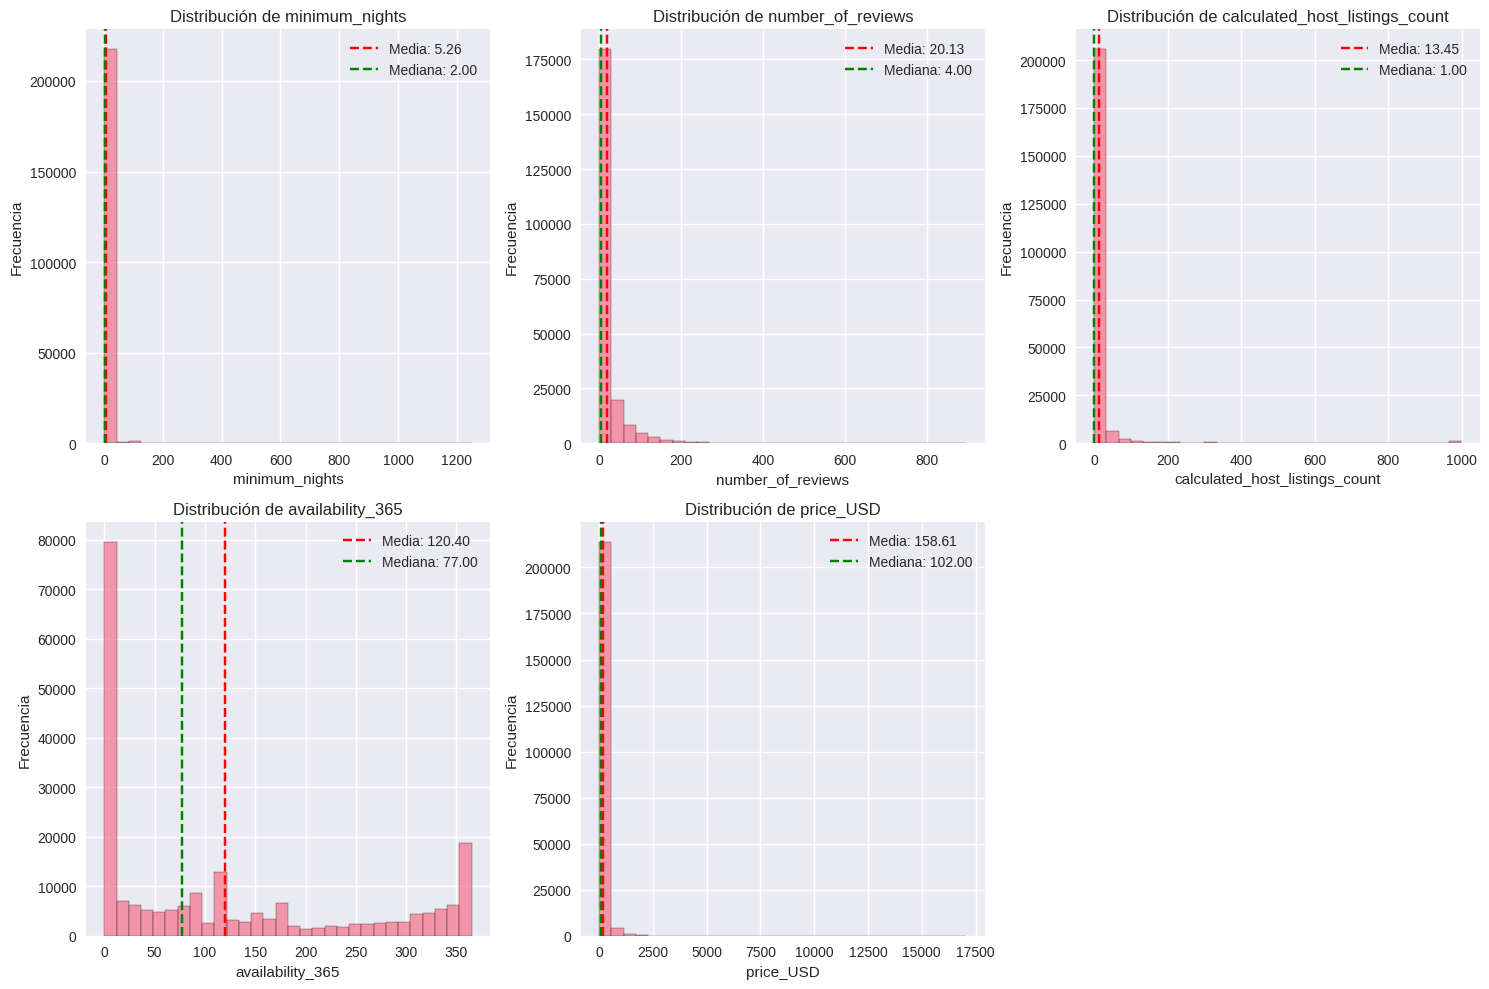


📦 Análisis de Outliers (Boxplots)


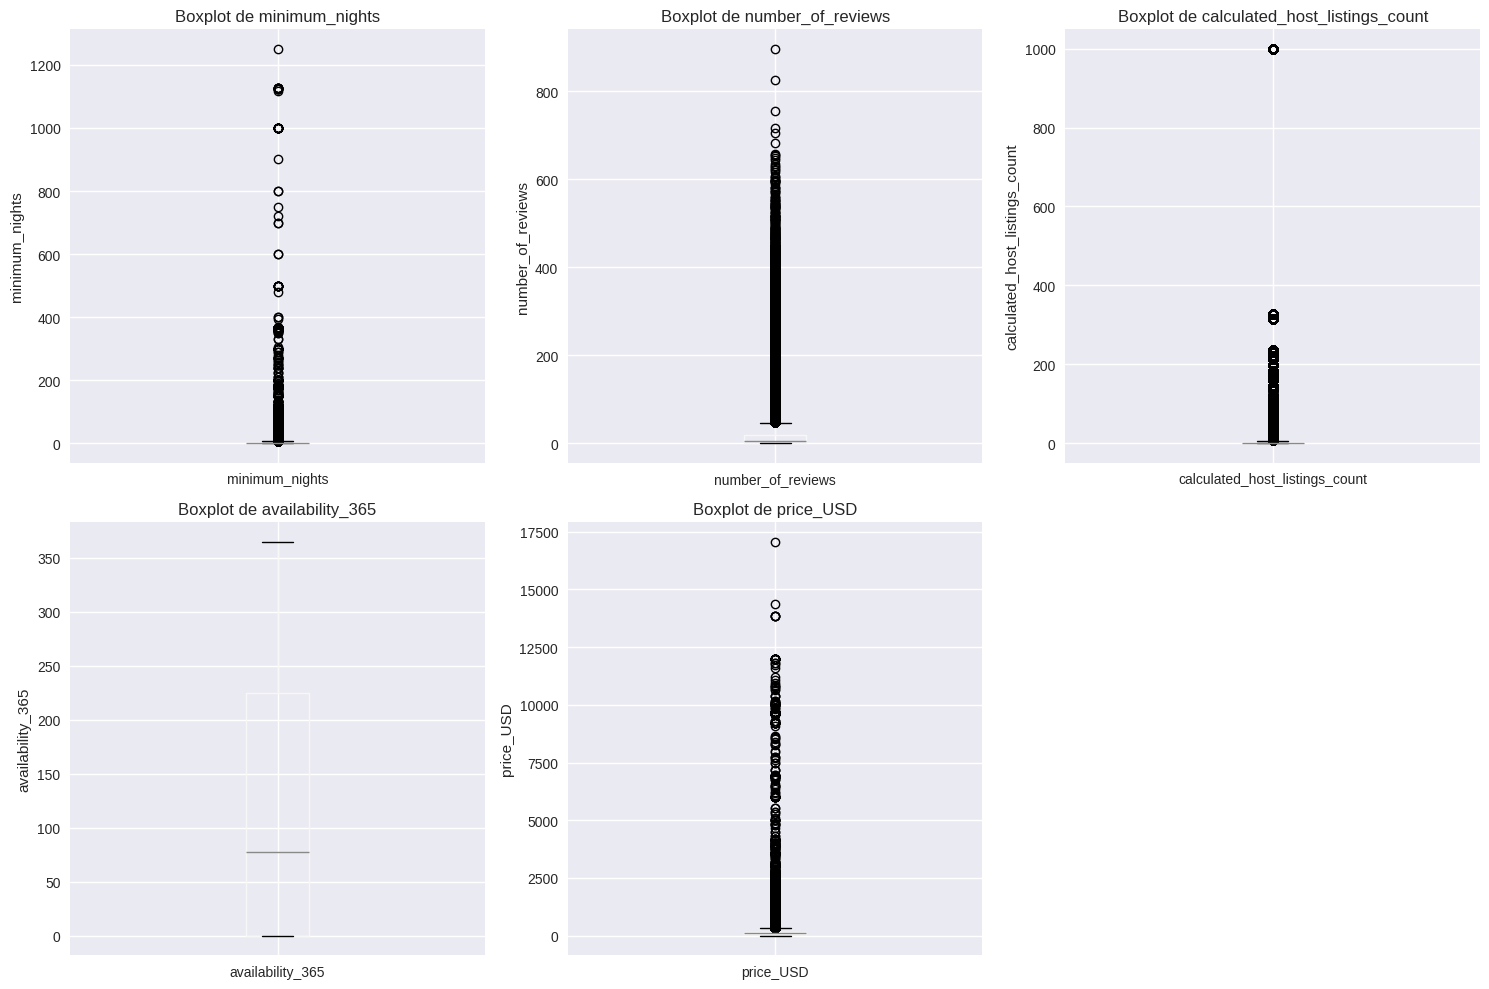


📊 Estadísticas de Forma de Distribución:


,Variable,Media,Mediana,Desv_Std,Asimetría,Curtosis,CV
0,minimum_nights,5.258,2.0,20.118,26.596,1129.434,382.620
1,number_of_reviews,20.129,4.0,43.012,4.663,32.419,213.681
2,calculated_host_listings_count,13.450,1.0,73.207,11.514,147.606,544.286
3,availability_365,120.404,77.0,131.103,0.732,-0.971,108.886
4,price_USD,158.612,102.0,323.146,21.362,648.610,203.733



🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS
----------------------------------------
Variables categóricas útiles encontradas: 3
  1. room_type (únicos: 4)
  2. city (únicos: 6)
  3. neighbourhood (únicos: 562)

📋 Análisis de 'room_type':
  Valores únicos: 4
  Valores más frecuentes:
    Entire home/apt: 128,154 (58.2%)
    Private room: 86,512 (39.3%)
    Shared room: 4,012 (1.8%)
    Hotel room: 1,353 (0.6%)


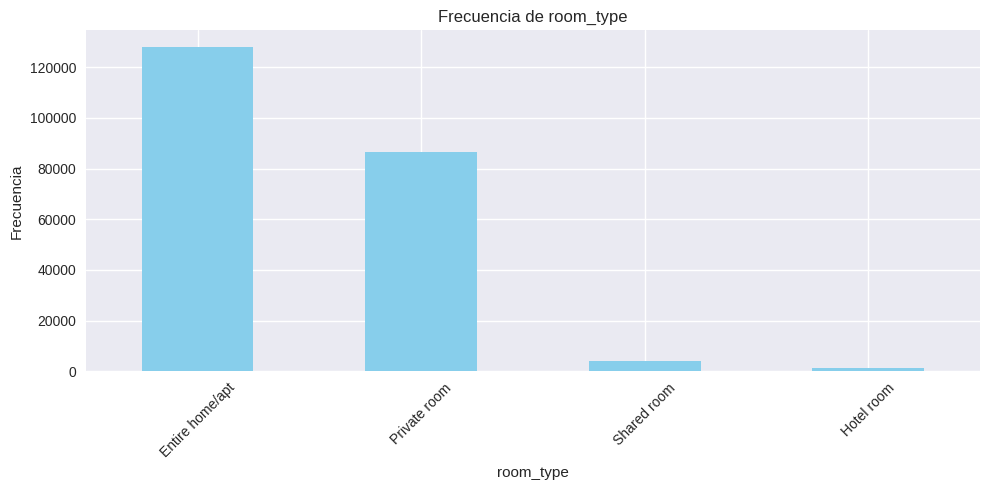


📋 Análisis de 'city':
  Valores únicos: 6
  Valores más frecuentes:
    London: 85,068 (38.7%)
    New York: 48,895 (22.2%)
    Sydney: 36,662 (16.7%)
    Madrid: 19,618 (8.9%)
    Milan: 18,322 (8.3%)
    Tokyo: 11,466 (5.2%)


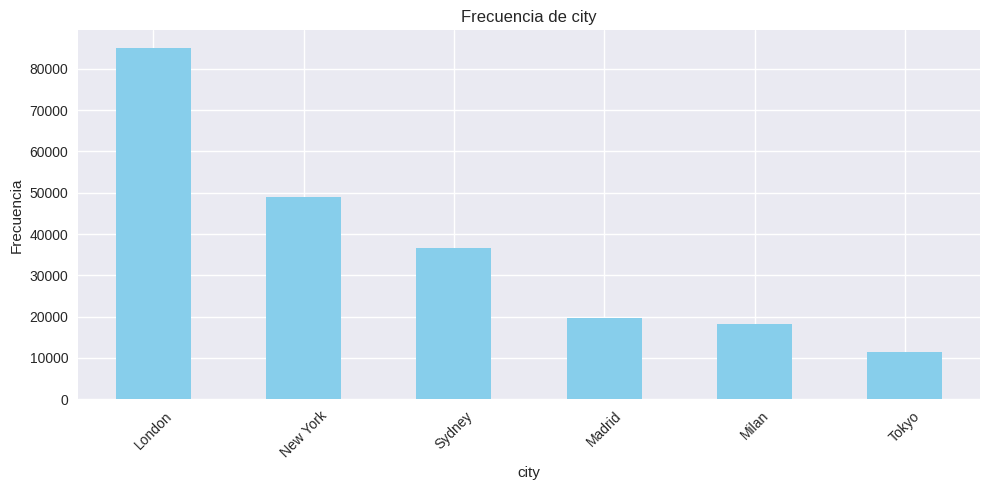


📋 Análisis de 'neighbourhood':
  Valores únicos: 562
  Valores más frecuentes:
    Westminster: 9,588 (4.4%)
    Sydney: 9,241 (4.2%)
    Tower Hamlets: 8,246 (3.7%)
    Hackney: 6,276 (2.9%)
    Kensington and Chelsea: 6,018 (2.7%)
    Camden: 6,001 (2.7%)
    Waverley: 5,467 (2.5%)
    Islington: 5,108 (2.3%)
    Southwark: 4,893 (2.2%)
    Lambeth: 4,854 (2.2%)


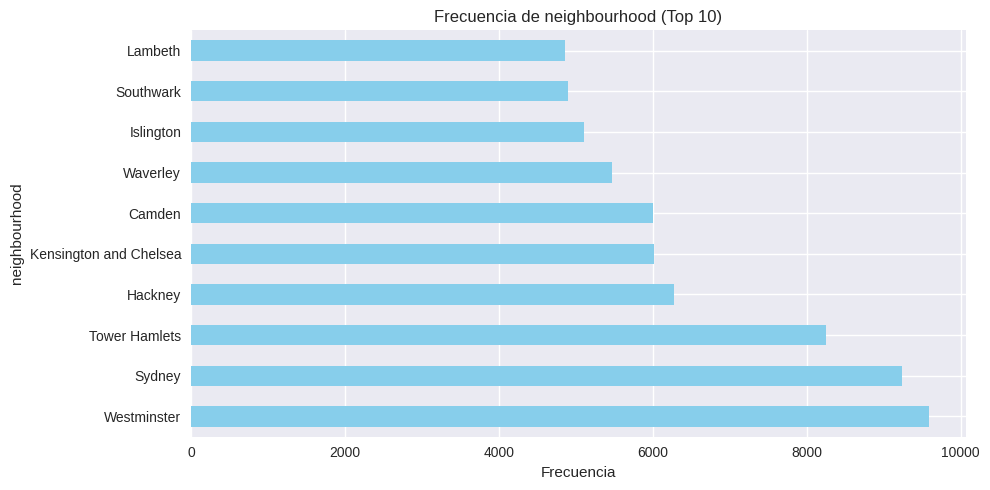

In [101]:
# Ejecutar análisis univariado
if df is not None:
    numeric_vars = analyze_numerical_variables(df)
    categorical_vars = analyze_categorical_variables(df)

##2. Análisis bivariado

- **Numéricas vs Numéricas**: Matriz de correlación, scatterplots de correlaciones fuertes
- **Categóricas vs Numéricas**: Boxplots por grupo, estadísticas descriptivas por categoría
- **Categóricas vs Categóricas**: Tablas de contingencia, test Chi-cuadrado

In [102]:
def analyze_numerical_relationships(df, numeric_cols):
    """
    Análisis bivariado entre variables numéricas
    """
    print("\n🔢 RELACIONES NUMÉRICAS")
    print("-" * 30)

    # Matriz de correlación
    correlation_matrix = df[numeric_cols].corr()

    # Visualización
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 10},
        cmap='RdBu_r',
        center=0,
        square=True,
        linewidths=1,
        vmin=-1, vmax=1
    )
    plt.title('Matriz de Correlación', fontsize=14, pad=15)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Se identifican correlaciones fuertes
    print("\n🔍 Correlaciones Significativas:")
    strong_corr = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.3:  # Umbral más bajo
                var1 = correlation_matrix.columns[i]
                var2 = correlation_matrix.columns[j]
                strong_corr.append((var1, var2, corr_value))

                level = "Fuerte" if abs(corr_value) > 0.5 else "Moderada"
                direction = "+" if corr_value > 0 else "-"
                print(f"  {var1} ↔ {var2}: {corr_value:.3f} ({level} {direction})")

    # Scatterplots de las mejores correlaciones
    if strong_corr:
        strong_corr.sort(key=lambda x: abs(x[2]), reverse=True)
        n_plots = min(4, len(strong_corr))

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()

        for i, (var1, var2, corr) in enumerate(strong_corr[:n_plots]):
            valid_data = df[[var1, var2]].dropna()

            # Scatter + línea de tendencia
            axes[i].scatter(valid_data[var1], valid_data[var2], alpha=0.6, s=40)

            if len(valid_data) > 1:
                z = np.polyfit(valid_data[var1], valid_data[var2], 1)
                p = np.poly1d(z)
                axes[i].plot(valid_data[var1], p(valid_data[var1]), "r--", alpha=0.8)

            axes[i].set_xlabel(var1)
            axes[i].set_ylabel(var2)
            axes[i].set_title(f'{var1} vs {var2} (r={corr:.2f})')
            axes[i].grid(True, alpha=0.3)

        # Ocultar plots vacíos
        for i in range(n_plots, 4):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()
    else:
        print("  No se encontraron correlaciones significativas (|r| > 0.3)")

    return strong_corr

In [103]:
def analyze_categorical_numerical_relationships(df, categorical_cols, numeric_cols):
    """
    Análisis bivariado entre variables categóricas y numéricas
    """
    print("\n🏷️🔢 RELACIONES CATEGÓRICAS vs NUMÉRICAS")
    print("-" * 45)

    for cat_var in categorical_cols:
        if df[cat_var].nunique() <= 6:
            print(f"\n📊 Análisis de '{cat_var}' vs variables numéricas:")

            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            axes = axes.flatten()

            for i, num_var in enumerate(numeric_cols):
                if i < 4:
                    # Boxplot
                    df.boxplot(column=num_var, by=cat_var, ax=axes[i])
                    axes[i].set_title(f'{num_var} por {cat_var}')
                    axes[i].set_xlabel(cat_var)
                    axes[i].set_ylabel(num_var)
                    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

            plt.suptitle('')  # Remover título automático
            plt.tight_layout()
            plt.show()

            # Estadísticas descriptivas por grupo
            print(f"  Estadísticas de variables numéricas por {cat_var}:")
            for num_var in numeric_cols:
                group_stats = df.groupby(cat_var)[num_var].agg(['count', 'mean', 'std', 'min', 'max'])
                print(f"\n  {num_var}:")
                display(group_stats.round(2))

In [104]:
def analyze_categorical_relationships(df, categorical_cols):
    """
    Análisis bivariado entre variables categóricas
    """
    print("\n🏷️🏷️ RELACIONES ENTRE CATEGÓRICAS")
    print("-" * 40)

    # Seleccionar pares de variables categóricas principales
    main_cats = categorical_cols[:4]

    for i, cat1 in enumerate(main_cats):
        for cat2 in main_cats[i+1:]:
            if df[cat1].nunique() <= 10 and df[cat2].nunique() <= 10:
                print(f"\n📊 Tabla cruzada: {cat1} vs {cat2}")

                # Tabla de contingencia
                contingency_table = pd.crosstab(df[cat1], df[cat2])
                print("Frecuencias absolutas:")
                display(contingency_table)

                # Porcentajes
                print("\nPorcentajes por filas:")
                display(pd.crosstab(df[cat1], df[cat2], normalize='index').round(3) * 100)

                # Heatmap de la tabla de contingencia
                plt.figure(figsize=(12, 8))
                sns.heatmap(
                    contingency_table,
                    annot=True,
                    fmt='d',
                    cmap='Blues',
                    cbar=False,
                    annot_kws={"size": 7}
                    )
                plt.title(f'Tabla de Contingencia: {cat1} vs {cat2}')
                plt.ylabel(cat1)
                plt.xlabel(cat2)
                plt.tight_layout()
                plt.show()

                # Chi-cuadrado (si tienes scipy)
                try:
                    from scipy.stats import chi2_contingency
                    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                    print(f"Test Chi-cuadrado: χ² = {chi2:.3f}, p-valor = {p_value:.3f}")
                    if p_value < 0.05:
                        print("✅ Existe asociación significativa (p < 0.05)")
                    else:
                        print("❌ No hay asociación significativa (p ≥ 0.05)")
                except ImportError:
                    print("💡 Instala scipy para realizar test de Chi-cuadrado")


🔢 RELACIONES NUMÉRICAS
------------------------------


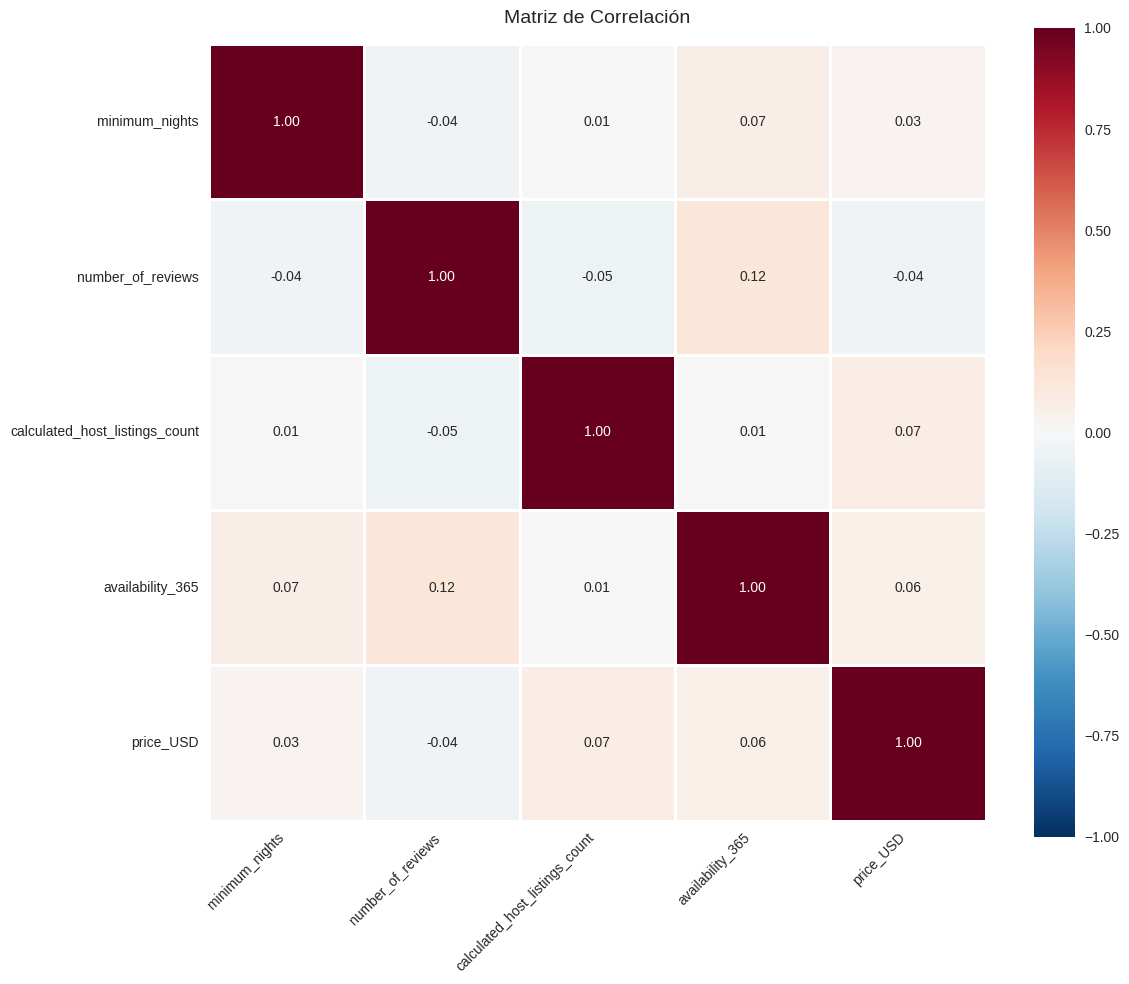


🔍 Correlaciones Significativas:
  No se encontraron correlaciones significativas (|r| > 0.3)

🏷️🔢 RELACIONES CATEGÓRICAS vs NUMÉRICAS
---------------------------------------------

📊 Análisis de 'room_type' vs variables numéricas:


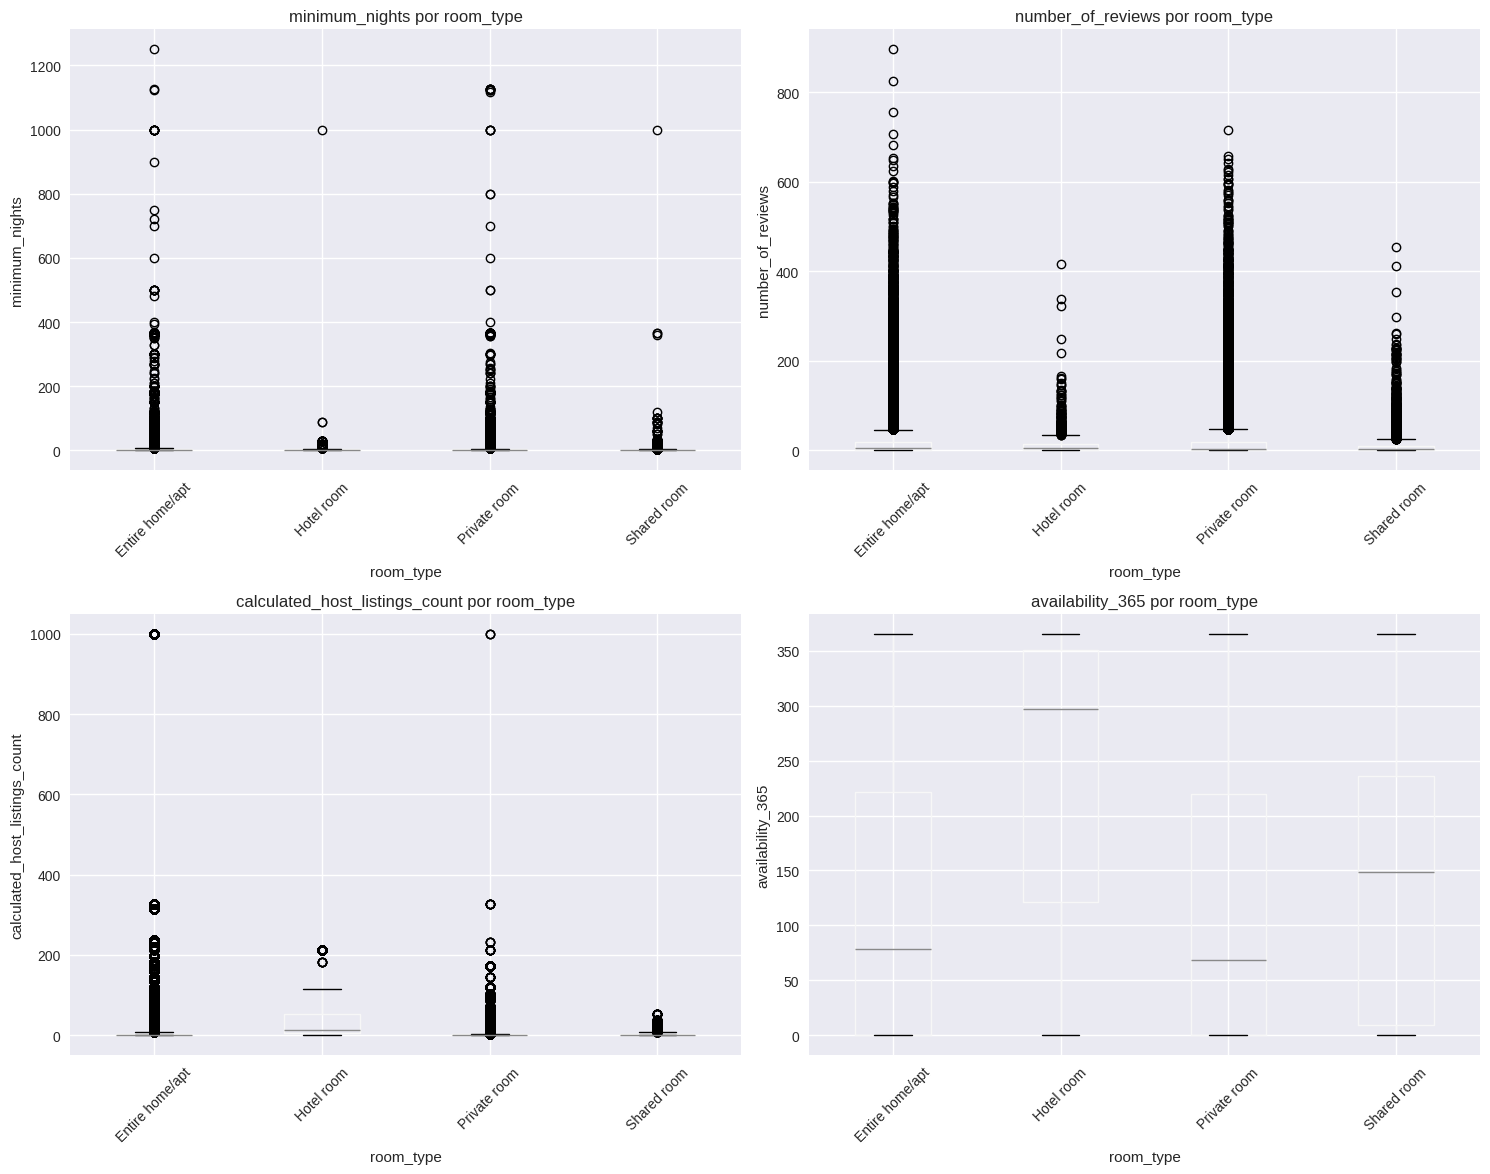

  Estadísticas de variables numéricas por room_type:

  minimum_nights:


,count,mean,std,min,max
room_type,,,,,
Entire home/apt,128154,5.84,20.00,1,1250
Hotel room,1353,4.10,27.77,1,1000
Private room,86512,4.48,20.12,1,1125
Shared room,4012,4.06,20.31,1,999



  number_of_reviews:


,count,mean,std,min,max
room_type,,,,,
Entire home/apt,128154,19.94,41.69,0,896
Hotel room,1353,13.72,29.13,0,416
Private room,86512,20.85,45.47,0,716
Shared room,4012,12.85,31.26,0,454



  calculated_host_listings_count:


,count,mean,std,min,max
room_type,,,,,
Entire home/apt,128154,19.87,94.37,0.0,999.0
Hotel room,1353,44.00,66.11,1.0,213.0
Private room,86512,3.89,13.97,0.0,999.0
Shared room,4012,4.32,7.75,0.0,52.0



  availability_365:


,count,mean,std,min,max
room_type,,,,,
Entire home/apt,128154,119.29,128.24,0.0,365.0
Hotel room,1353,238.51,129.66,0.0,365.0
Private room,86512,118.90,134.38,0.0,365.0
Shared room,4012,148.37,129.39,0.0,365.0



  price_USD:


,count,mean,std,min,max
room_type,,,,,
Entire home/apt,128154,209.70,369.83,0.0,17078.76
Hotel room,1353,345.50,998.71,0.0,13833.17
Private room,86512,84.49,190.28,0.0,10862.89
Shared room,4012,62.08,134.63,0.0,3594.39



📊 Análisis de 'city' vs variables numéricas:


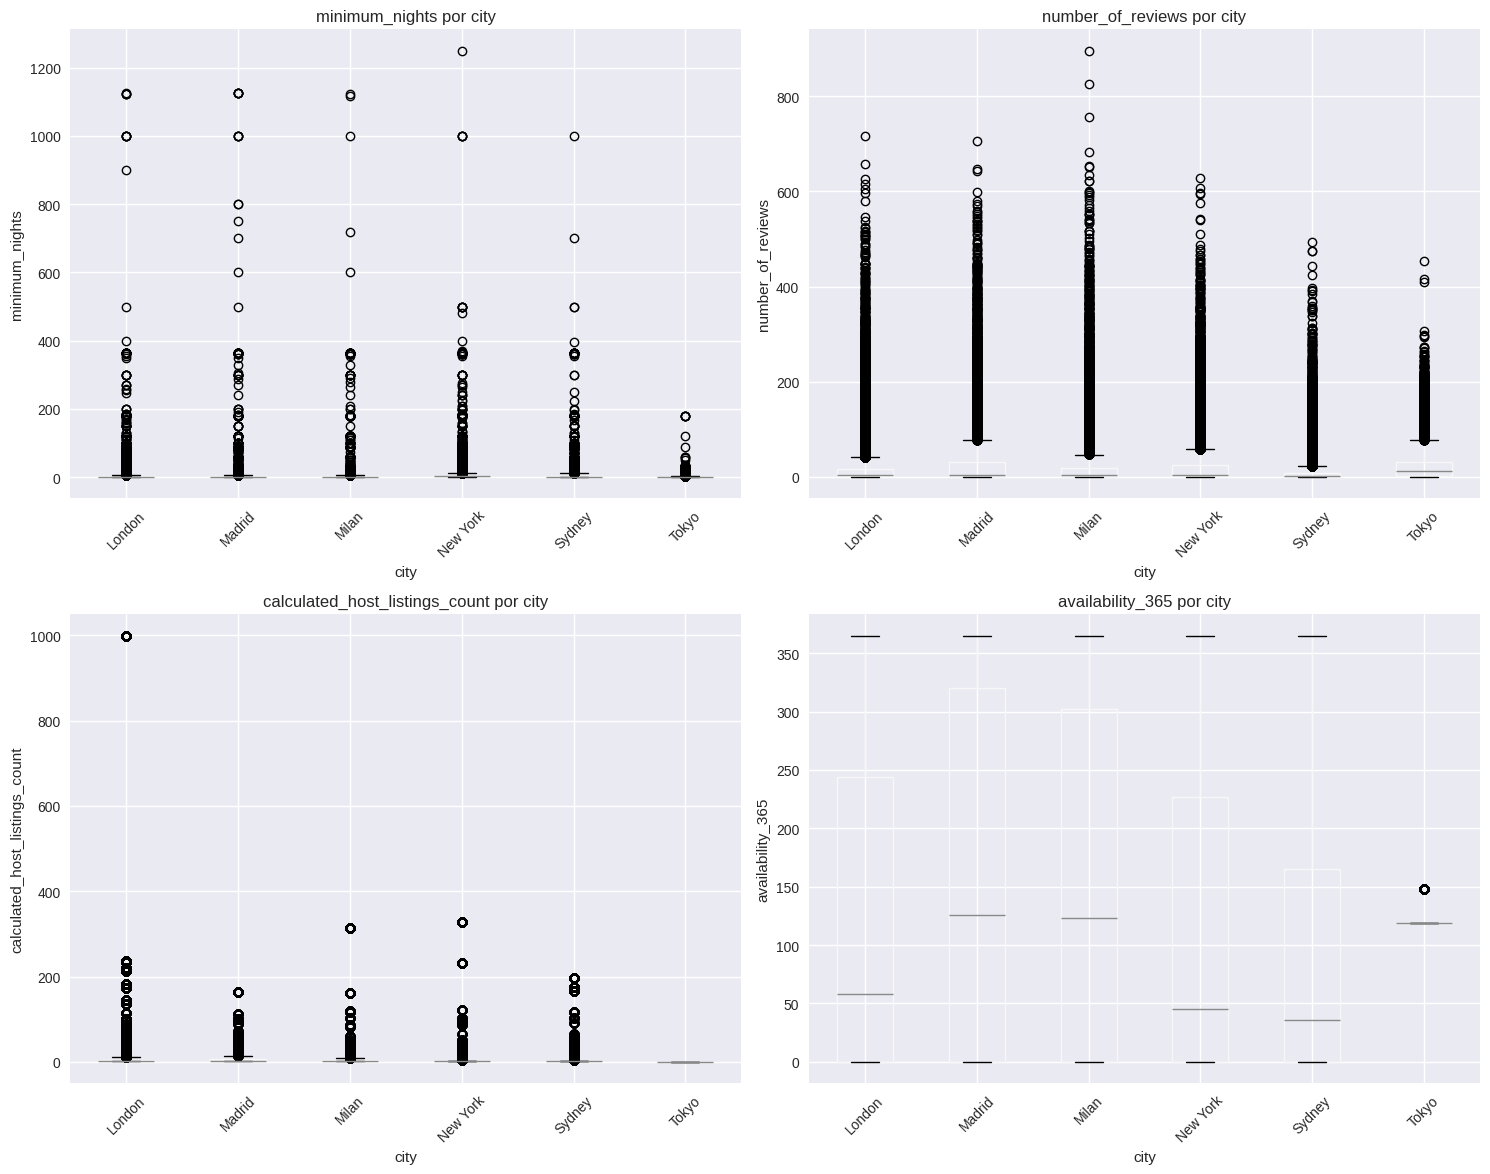

  Estadísticas de variables numéricas por city:

  minimum_nights:


,count,mean,std,min,max
city,,,,,
London,85068,4.15,16.68,1,1125
Madrid,19618,6.59,33.29,1,1125
Milan,18322,5.80,26.69,1,1124
New York,48895,7.03,20.51,1,1250
Sydney,36662,5.10,15.66,1,1000
Tokyo,11466,3.32,7.77,1,180



  number_of_reviews:


,count,mean,std,min,max
city,,,,,
London,85068,17.47,36.79,0,716
Madrid,19618,31.86,63.94,0,706
Milan,18322,23.72,57.66,0,896
New York,48895,23.27,44.55,0,629
Sydney,36662,12.19,28.65,0,493
Tokyo,11466,26.03,38.46,0,453



  calculated_host_listings_count:


,count,mean,std,min,max
city,,,,,
London,85068,22.15,110.65,1.0,999.0
Madrid,19618,10.23,23.55,1.0,163.0
Milan,18322,14.42,46.30,1.0,314.0
New York,48895,7.14,32.95,1.0,327.0
Sydney,36662,7.12,24.61,1.0,197.0
Tokyo,11466,0.00,0.00,0.0,0.0



  availability_365:


,count,mean,std,min,max
city,,,,,
London,85068,118.47,134.84,0.0,365.00
Madrid,19618,159.10,144.25,0.0,365.00
Milan,18322,153.51,138.76,0.0,365.00
New York,48895,112.78,131.62,0.0,365.00
Sydney,36662,97.39,122.97,0.0,365.00
Tokyo,11466,121.72,8.23,118.9,148.37



  price_USD:


,count,mean,std,min,max
city,,,,,
London,85068,169.25,305.40,0.00,17078.76
Madrid,19618,154.88,580.07,0.00,11980.12
Milan,18322,137.90,348.41,9.59,14376.38
New York,48895,152.72,240.15,0.00,10000.00
Sydney,36662,160.66,250.50,0.00,11602.77
Tokyo,11466,137.75,305.88,0.00,9193.28



🏷️🏷️ RELACIONES ENTRE CATEGÓRICAS
----------------------------------------

📊 Tabla cruzada: room_type vs city
Frecuencias absolutas:


city,London,Madrid,Milan,New York,Sydney,Tokyo
room_type,,,,,,
Entire home/apt,47445,11314,13605,25409,22918,7463
Hotel room,1113,166,74,0,0,0
Private room,35882,7809,4376,22326,13115,3004
Shared room,628,329,267,1160,629,999



Porcentajes por filas:


city,London,Madrid,Milan,New York,Sydney,Tokyo
room_type,,,,,,
Entire home/apt,37.0,8.8,10.6,19.8,17.9,5.8
Hotel room,82.3,12.3,5.5,0.0,0.0,0.0
Private room,41.5,9.0,5.1,25.8,15.2,3.5
Shared room,15.7,8.2,6.7,28.9,15.7,24.9


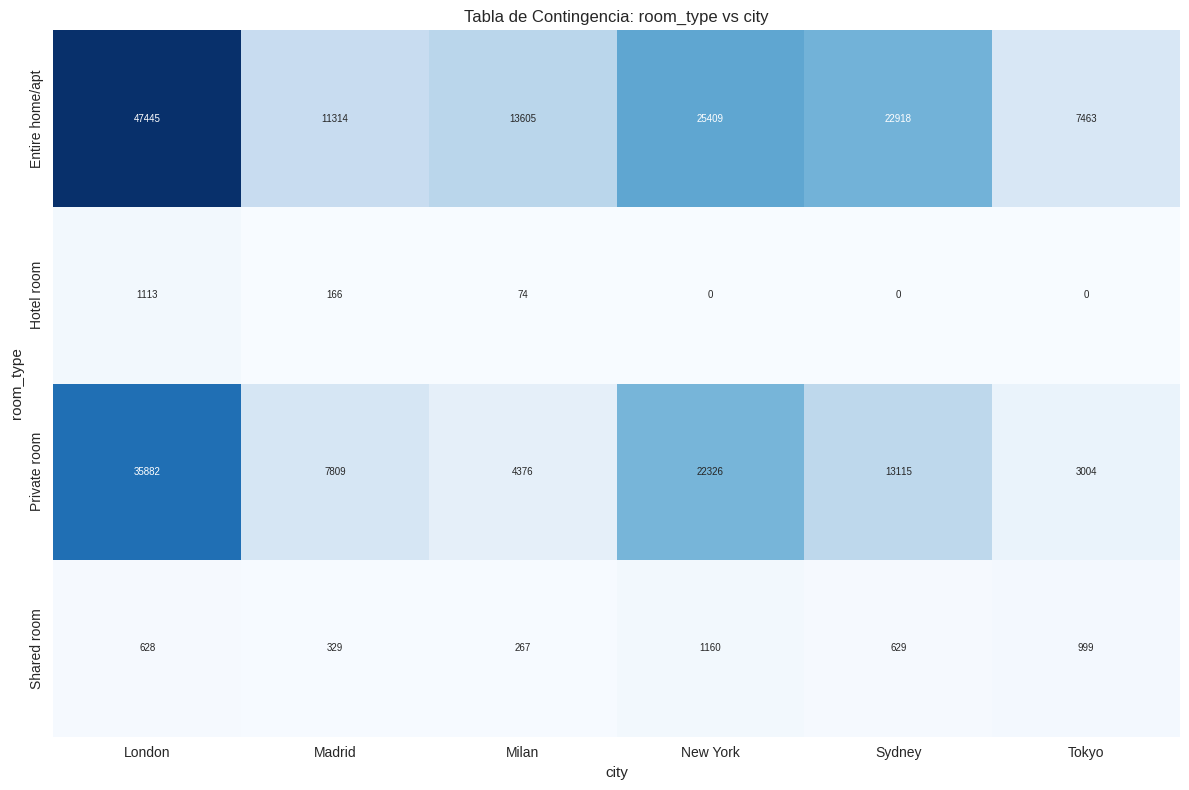

Test Chi-cuadrado: χ² = 8767.451, p-valor = 0.000
✅ Existe asociación significativa (p < 0.05)


In [105]:
if df is not None and 'numeric_vars' in locals() and 'categorical_vars' in locals():
    strong_correlations = analyze_numerical_relationships(df, numeric_vars)
    analyze_categorical_numerical_relationships(df, categorical_vars, numeric_vars)
    analyze_categorical_relationships(df, categorical_vars)

##3. Análisis multivariado

- **Análisis por ciudades**: Comparaciones múltiples entre ciudades
- **PCA**: Reducción de dimensionalidad, scree plot, biplot, loadings
- **Visualizaciones avanzadas**: Coordenadas paralelas, matriz de scatter plots

In [106]:
def analyze_multiple_relationships(df, numeric_cols, categorical_cols):
    """
    Análisis multivariado mejorado con explicaciones detalladas
    """
    print("\n🔗 ANÁLISIS DE MÚLTIPLES VARIABLES")
    print("-" * 50)

    # 1. Análisis por ciudad
    if 'city' in df.columns:
        print("\n📊 Análisis por Ciudad:")

        # Estadísticas por ciudad
        city_stats = df.groupby('city')[numeric_cols[:5]].agg(['mean', 'std', 'count'])
        print("Estadísticas por ciudad:")
        display(city_stats.round(2))

        # Visualización comparativa por ciudad
        if len(numeric_cols) >= 2:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # 1. Box plot por ciudad - Variable más representativa
            df.boxplot(column='price_USD', by='city', ax=axes[0])
            axes[0].set_title('Distribución de Precios por Ciudad')
            axes[0].set_xlabel('Ciudad')
            axes[0].set_ylabel('Precio (USD)')
            plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

            # 2. Histograma por ciudad
            cities = df['city'].unique()
            colors = plt.cm.Set3(np.linspace(0, 1, len(cities)))

            print(f"\n📊 Analizando distribución de precios en las {len(cities)} ciudades:")
            for i, city in enumerate(cities):
                city_data = df[df['city'] == city]['price_USD']
                # Filtrar outliers extremos para mejor visualización
                city_data_filtered = city_data[city_data <= city_data.quantile(0.95)]
                axes[1].hist(city_data_filtered, alpha=0.6, label=city,
                           bins=30, color=colors[i])

            axes[1].set_xlabel('Precio (USD)')
            axes[1].set_ylabel('Frecuencia')
            axes[1].set_title('Distribución de Precios por Ciudad (sin outliers extremos)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            # 3. Análisis de correlación por las 3 ciudades principales
            print(f"\n📊 ¿Por qué solo 3 ciudades en correlación?")
            print("Se seleccionan las 3 ciudades con más datos para análisis estadístico confiable:")

            # Ordenar ciudades por cantidad de datos
            city_counts = df['city'].value_counts()
            top_3_cities = city_counts.head(3).index

            for i, city in enumerate(city_counts.head(6).items()):
                print(f"  {i+1}. {city[0]}: {city[1]:,} registros")

            print(f"\nSeleccionadas para correlación: {', '.join(top_3_cities)}")

            # Correlación entre price_USD y number_of_reviews por ciudad
            corr_data = []
            corr_labels = []

            for city in top_3_cities:
                city_df = df[df['city'] == city]
                if len(city_df) > 100:  # Mínimo de datos para correlación confiable
                    corr_value = city_df['price_USD'].corr(city_df['number_of_reviews'])
                    corr_data.append(corr_value)
                    corr_labels.append(f"{city}\n(n={len(city_df):,})")

            if corr_data:
                bars = axes[2].bar(range(len(corr_data)), corr_data,
                                 color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
                axes[2].set_title('Correlación Precio-Reviews por Ciudad\n(Top 3 ciudades)')
                axes[2].set_ylabel('Correlación (Pearson)')
                axes[2].set_xticks(range(len(corr_labels)))
                axes[2].set_xticklabels(corr_labels, rotation=0)
                axes[2].grid(True, alpha=0.3)
                axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)

                # Añadir valores en las barras
                for bar, value in zip(bars, corr_data):
                    height = bar.get_height()
                    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                                f'{value:.3f}', ha='center',
                                va='bottom' if value >= 0 else 'top')

            plt.tight_layout()
            plt.show()

            # Interpretación de los gráficos
            print("\n🔍 INTERPRETACIÓN DE LOS GRÁFICOS:")
            print("1. Box Plot (Precios por Ciudad):")
            print("   - Compara la distribución de precios entre ciudades")
            print("   - La línea central es la mediana, la caja muestra Q1-Q3")

            print("\n2. Histograma (Distribución de Precios):")
            print("   - Muestra la forma de distribución en cada ciudad")
            print("   - Se excluyen outliers extremos para mejor visualización")

            print("\n3. Correlación (Precio vs Reviews):")
            print("   - Muestra si más reviews se asocia con precios más altos/bajos")
            print("   - Solo top 3 ciudades para análisis estadísticamente confiable")

In [107]:
def perform_dimensionality_reduction(df, numeric_cols):
    """
    Análisis de reducción de dimensionalidad (PCA)
    """
    print("\n📊 ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
    print("-" * 50)

    try:
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler

        # Preparar datos (solo variables numéricas sin NaN)
        pca_data = df[numeric_cols].dropna()

        if len(pca_data) < 50:
            print("⚠️ Pocos datos para PCA confiable")
            return

        # Estandarizar datos
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(pca_data)

        # Aplicar PCA
        pca = PCA()
        pca_result = pca.fit_transform(scaled_data)

        # Varianza explicada
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        print(f"Varianza explicada por componente:")
        for i, var in enumerate(explained_variance[:5]):
            print(f"  PC{i+1}: {var:.3f} ({var*100:.1f}%)")

        print(f"\nVarianza acumulada:")
        for i, cum_var in enumerate(cumulative_variance[:5]):
            print(f"  PC1-PC{i+1}: {cum_var:.3f} ({cum_var*100:.1f}%)")

        # Visualizaciones
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Scree plot
        axes[0,0].plot(range(1, len(explained_variance[:10])+1), explained_variance[:10], 'bo-')
        axes[0,0].set_xlabel('Componente Principal')
        axes[0,0].set_ylabel('Varianza Explicada')
        axes[0,0].set_title('Scree Plot')
        axes[0,0].grid(True)

        # Varianza acumulada
        axes[0,1].plot(range(1, len(cumulative_variance[:10])+1), cumulative_variance[:10], 'ro-')
        axes[0,1].axhline(y=0.8, color='k', linestyle='--', alpha=0.7, label='80%')
        axes[0,1].set_xlabel('Componente Principal')
        axes[0,1].set_ylabel('Varianza Acumulada')
        axes[0,1].set_title('Varianza Acumulada')
        axes[0,1].legend()
        axes[0,1].grid(True)

        # Biplot (PC1 vs PC2)
        axes[1,0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=30)
        axes[1,0].set_xlabel(f'PC1 ({explained_variance[0]:.1%})')
        axes[1,0].set_ylabel(f'PC2 ({explained_variance[1]:.1%})')
        axes[1,0].set_title('Biplot PC1 vs PC2')
        axes[1,0].grid(True)

        # Loadings plot
        loadings = pca.components_[:2].T
        for i, var in enumerate(numeric_cols[:len(loadings)]):
            axes[1,1].arrow(0, 0, loadings[i, 0], loadings[i, 1],
                           head_width=0.05, head_length=0.05, fc='red', ec='red')
            axes[1,1].text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, fontsize=8)

        axes[1,1].set_xlabel('PC1')
        axes[1,1].set_ylabel('PC2')
        axes[1,1].set_title('Loadings Plot')
        axes[1,1].grid(True)
        axes[1,1].set_xlim(-1, 1)
        axes[1,1].set_ylim(-1, 1)

        plt.tight_layout()
        plt.show()

        # Interpretación
        print("\n💡 Interpretación:")
        n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
        print(f"  - Se necesitan {n_components_80} componentes para explicar el 80% de la varianza")

        print(f"\n📊 Contribución de variables a PC1:")
        pc1_contributions = pd.DataFrame({
            'Variable': numeric_cols[:len(pca.components_[0])],
            'Contribución': pca.components_[0]
        }).sort_values('Contribución', key=abs, ascending=False)
        display(pc1_contributions.head(8))

    except ImportError:
        print("💡 Instala scikit-learn para análisis PCA: pip install scikit-learn")


🔗 ANÁLISIS DE MÚLTIPLES VARIABLES
--------------------------------------------------

📊 Análisis por Ciudad:
Estadísticas por ciudad:


minimum_nights               number_of_reviews                \
                   mean    std  count              mean    std  count   
city                                                                    
London             4.15  16.68  85068             17.47  36.79  85068   
Madrid             6.59  33.29  19618             31.86  63.94  19618   
Milan              5.80  26.69  18322             23.72  57.66  18322   
New York           7.03  20.51  48895             23.27  44.55  48895   
Sydney             5.10  15.66  36662             12.19  28.65  36662   
Tokyo              3.32   7.77  11466             26.03  38.46  11466   

         calculated_host_listings_count                availability_365  \
                                   mean     std  count             mean   
city                                                                      
London                            22.15  110.65  85068           118.47   
Madrid                            10.23   23.55  19618           159.10   
Milan                             14.42   46.30  18322           153.51   
New York                           7.14   32.95  48895           112.78   
Sydney                             7.12   24.61  36662            97.39   
Tokyo                              0.00    0.00  11466           121.72   

                        price_USD                 
             std  count      mean     std  count  
city                                              
London    134.84  85068    169.25  305.40  85068  
Madrid    144.25  19618    154.88  580.07  19618  
Milan     138.76  18322    137.90  348.41  18322  
New York  131.62  48895    152.72  240.15  48895  
Sydney    122.97  36662    160.66  250.50  36662  
Tokyo       8.23  11466    137.75  305.88  11466


📊 Analizando distribución de precios en las 6 ciudades:

📊 ¿Por qué solo 3 ciudades en correlación?
Se seleccionan las 3 ciudades con más datos para análisis estadístico confiable:
  1. London: 85,068 registros
  2. New York: 48,895 registros
  3. Sydney: 36,662 registros
  4. Madrid: 19,618 registros
  5. Milan: 18,322 registros
  6. Tokyo: 11,466 registros

Seleccionadas para correlación: London, New York, Sydney


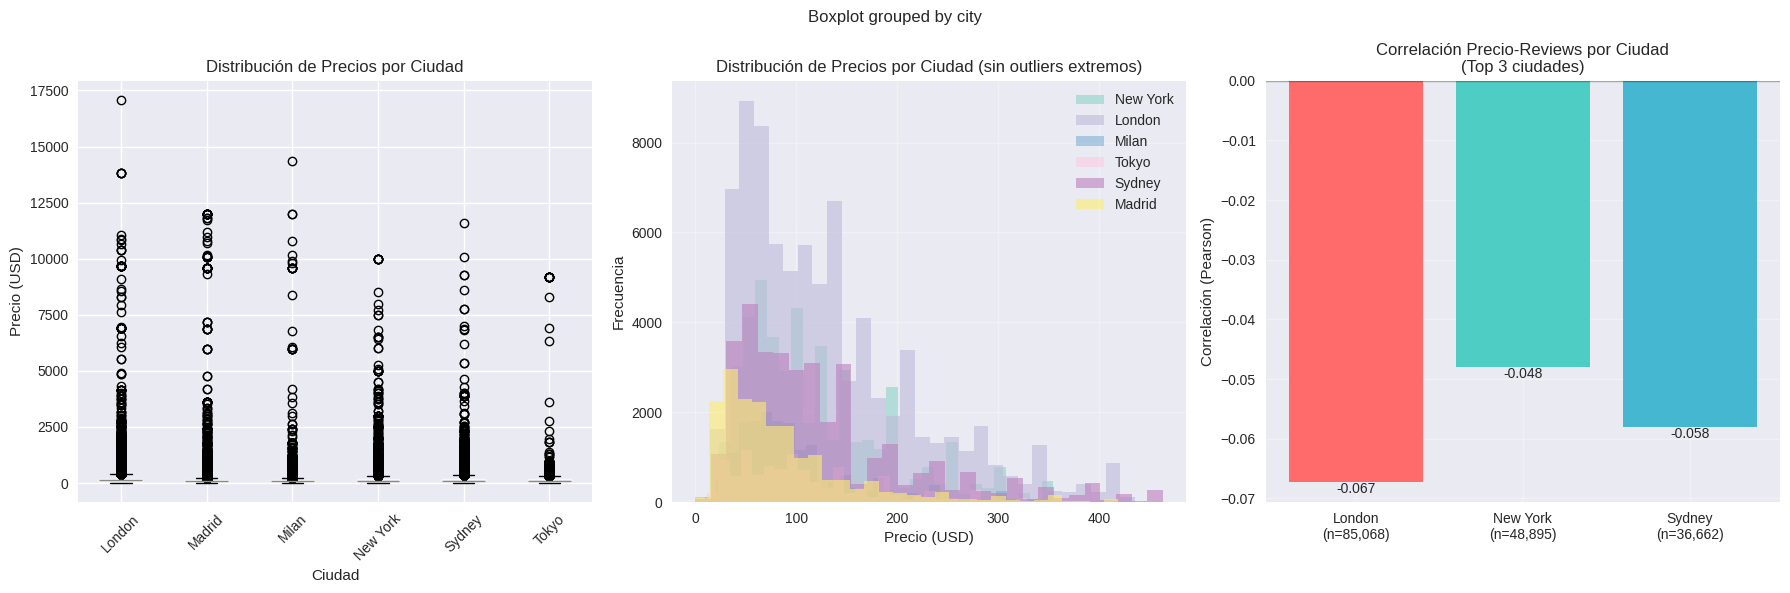


🔍 INTERPRETACIÓN DE LOS GRÁFICOS:
1. Box Plot (Precios por Ciudad):
   - Compara la distribución de precios entre ciudades
   - La línea central es la mediana, la caja muestra Q1-Q3

2. Histograma (Distribución de Precios):
   - Muestra la forma de distribución en cada ciudad
   - Se excluyen outliers extremos para mejor visualización

3. Correlación (Precio vs Reviews):
   - Muestra si más reviews se asocia con precios más altos/bajos
   - Solo top 3 ciudades para análisis estadísticamente confiable

📊 ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
--------------------------------------------------
Varianza explicada por componente:
  PC1: 0.226 (22.6%)
  PC2: 0.225 (22.5%)
  PC3: 0.200 (20.0%)
  PC4: 0.184 (18.4%)
  PC5: 0.165 (16.5%)

Varianza acumulada:
  PC1-PC1: 0.226 (22.6%)
  PC1-PC2: 0.451 (45.1%)
  PC1-PC3: 0.651 (65.1%)
  PC1-PC4: 0.835 (83.5%)
  PC1-PC5: 1.000 (100.0%)


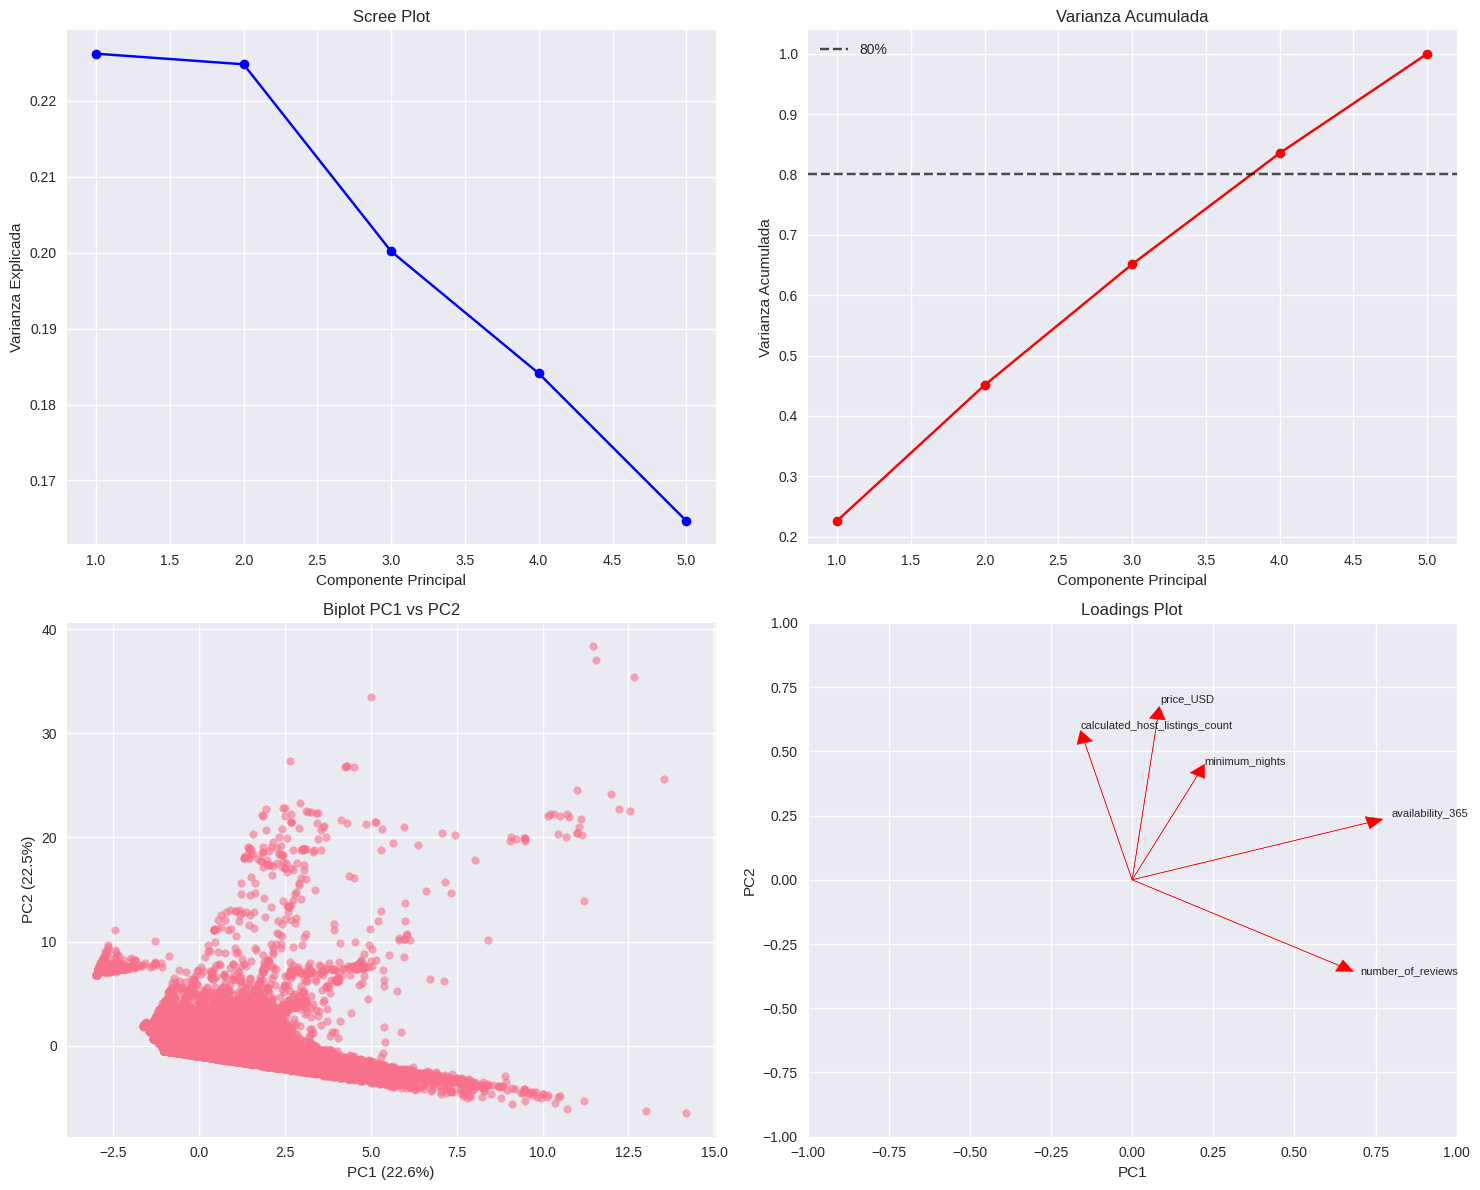


💡 Interpretación:
  - Se necesitan 4 componentes para explicar el 80% de la varianza

📊 Contribución de variables a PC1:


,Variable,Contribución
3,availability_365,0.724905
1,number_of_reviews,0.637789
0,minimum_nights,0.200974
2,calculated_host_listings_count,-0.145934
4,price_USD,0.077786


In [108]:
if df is not None and 'numeric_vars' in locals() and 'categorical_vars' in locals():
    analyze_multiple_relationships(df, numeric_vars, categorical_vars)
    perform_dimensionality_reduction(df, numeric_vars)

##4. Conclusiones

In [109]:
def generate_analysis_summary(df, numeric_cols, categorical_cols):
    """
    Genera un resumen ejecutivo del análisis
    """
    print("\n🎯 HALLAZGOS PRINCIPALES:")
    print("-" * 25)

    # Información general
    print(f"📊 Dataset: {len(df):,} registros × {len(df.columns)} variables")
    print(f"🏙️ Ciudades analizadas: {df['city'].nunique() if 'city' in df.columns else 'N/A'}")
    print(f"🔢 Variables numéricas analizadas: {len(numeric_cols)}")
    print(f"🏷️ Variables categóricas analizadas: {len(categorical_cols)}")

    # Estadísticas clave
    print(f"\n📈 ESTADÍSTICAS CLAVE:")
    for col in numeric_cols[:5]:
        print(f"  {col}:")
        print(f"    Media: {df[col].mean():.2f}")
        print(f"    Mediana: {df[col].median():.2f}")
        print(f"    Desv. Estándar: {df[col].std():.2f}")
        print(f"    Rango: {df[col].min():.2f} - {df[col].max():.2f}")

    # Valores faltantes
    missing_data = df.isnull().sum()
    total_missing = missing_data.sum()

    print(f"\n🔍 CALIDAD DE DATOS:")
    print(f"  Total valores faltantes: {total_missing:,}")
    if total_missing > 0:
        print(f"  Variables con datos faltantes:")
        for col, missing_count in missing_data[missing_data > 0].items():
            percentage = (missing_count / len(df)) * 100
            print(f"    {col}: {missing_count:,} ({percentage:.1f}%)")
    else:
        print("  ✅ No hay valores faltantes")

    # Distribuciones asimétricas
    print(f"\n📊 DISTRIBUCIONES:")
    for col in numeric_cols[:5]:
        skewness = df[col].skew()
        if abs(skewness) > 1:
            dist_type = "muy asimétrica"
        elif abs(skewness) > 0.5:
            dist_type = "moderadamente asimétrica"
        else:
            dist_type = "aproximadamente simétrica"

        direction = "positiva" if skewness > 0 else "negativa"
        print(f"  {col}: {dist_type} ({direction}, skew={skewness:.2f})")

    # Outliers
    print(f"\n🎯 DETECCIÓN DE OUTLIERS (Método IQR):")
    for col in numeric_cols[:5]:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percentage = (len(outliers) / len(df)) * 100

        print(f"  {col}: {len(outliers):,} outliers ({outlier_percentage:.1f}%)")

In [110]:
if df is not None and 'numeric_vars' in locals() and 'categorical_vars' in locals():
    generate_analysis_summary(df, numeric_vars, categorical_vars)


🎯 HALLAZGOS PRINCIPALES:
-------------------------
📊 Dataset: 220,031 registros × 17 variables
🏙️ Ciudades analizadas: 6
🔢 Variables numéricas analizadas: 5
🏷️ Variables categóricas analizadas: 3

📈 ESTADÍSTICAS CLAVE:
  minimum_nights:
    Media: 5.26
    Mediana: 2.00
    Desv. Estándar: 20.12
    Rango: 1.00 - 1250.00
  number_of_reviews:
    Media: 20.13
    Mediana: 4.00
    Desv. Estándar: 43.01
    Rango: 0.00 - 896.00
  calculated_host_listings_count:
    Media: 13.45
    Mediana: 1.00
    Desv. Estándar: 73.21
    Rango: 0.00 - 999.00
  availability_365:
    Media: 120.40
    Mediana: 77.00
    Desv. Estándar: 131.10
    Rango: 0.00 - 365.00
  price_USD:
    Media: 158.61
    Mediana: 102.00
    Desv. Estándar: 323.15
    Rango: 0.00 - 17078.76

🔍 CALIDAD DE DATOS:
  Total valores faltantes: 0
  ✅ No hay valores faltantes

📊 DISTRIBUCIONES:
  minimum_nights: muy asimétrica (positiva, skew=26.60)
  number_of_reviews: muy asimétrica (positiva, skew=4.66)
  calculated_host_listi